# Attempting to Implement an Image Segmentation model using OpenCV to remove background of Images.

## Aditya Kulkarni
November 12 2020
-----
-----

### **Step Zero:** Set up- We are using a open source OpenCV model to remove the background of a vanilla ice cream photo.

In [ ]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt  
# Model implemented from model.yml.gz https://github.com/opencv/opencv_extra/blob/master/testdata/cv/ximgproc/model.yml.gz

Initial Image to be processed:

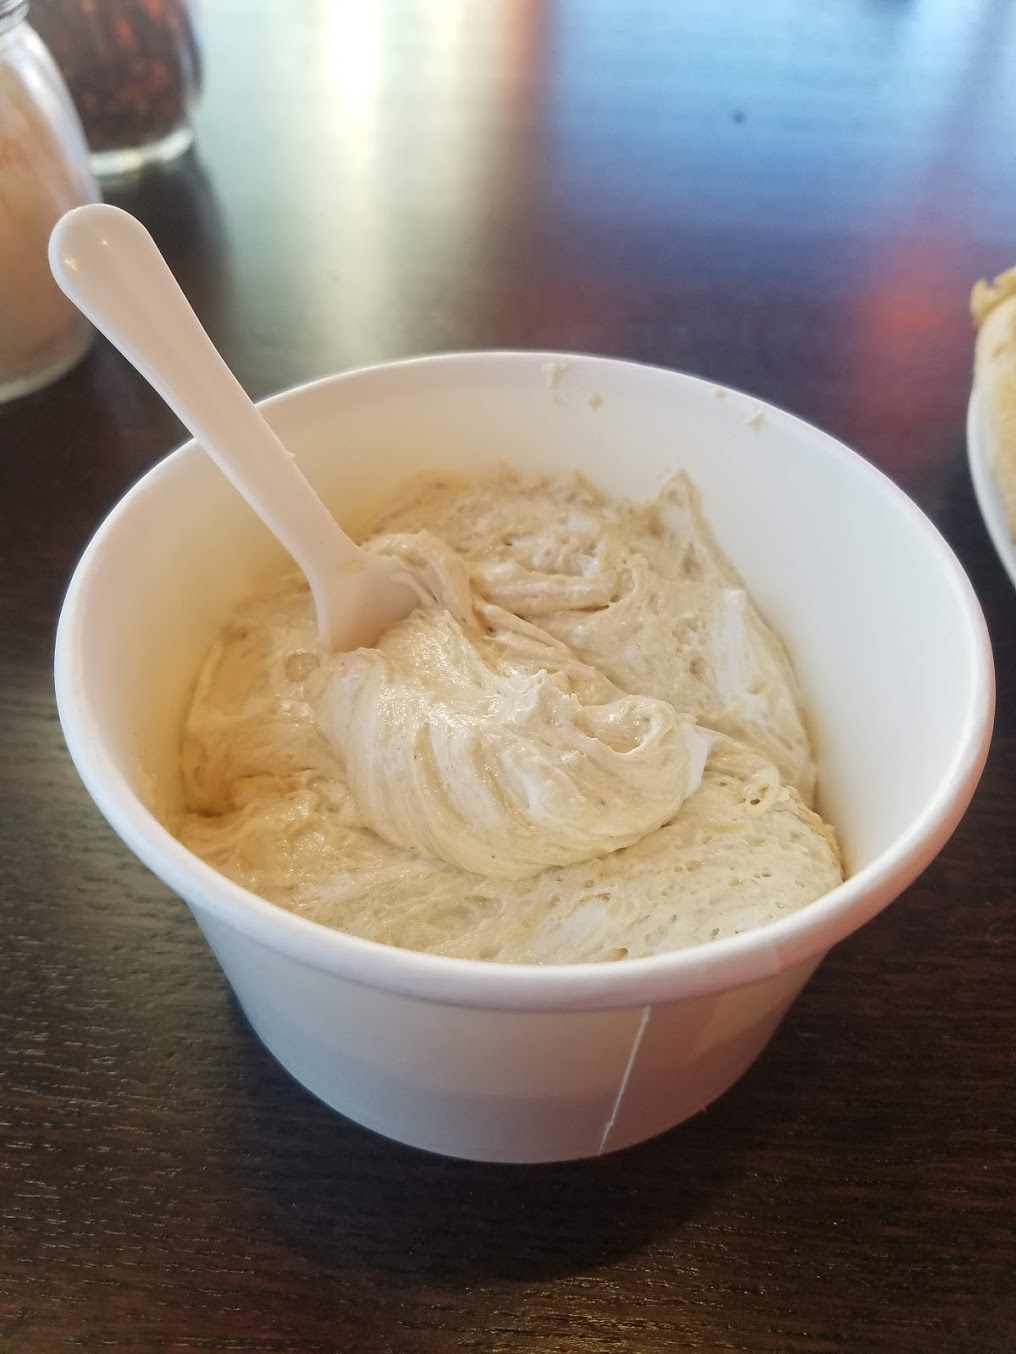

In [ ]:
from google.colab.patches import cv2_imshow
initial_img = cv2.imread('image.jpg')
cv2_imshow(initial_img)

### **First Step:** Gaussian Blur- This pre-processing technique minimizes the image noise.

We observed that the initial image did not have too much background noise. Hence, there is not much different between these two images to the naked eye.

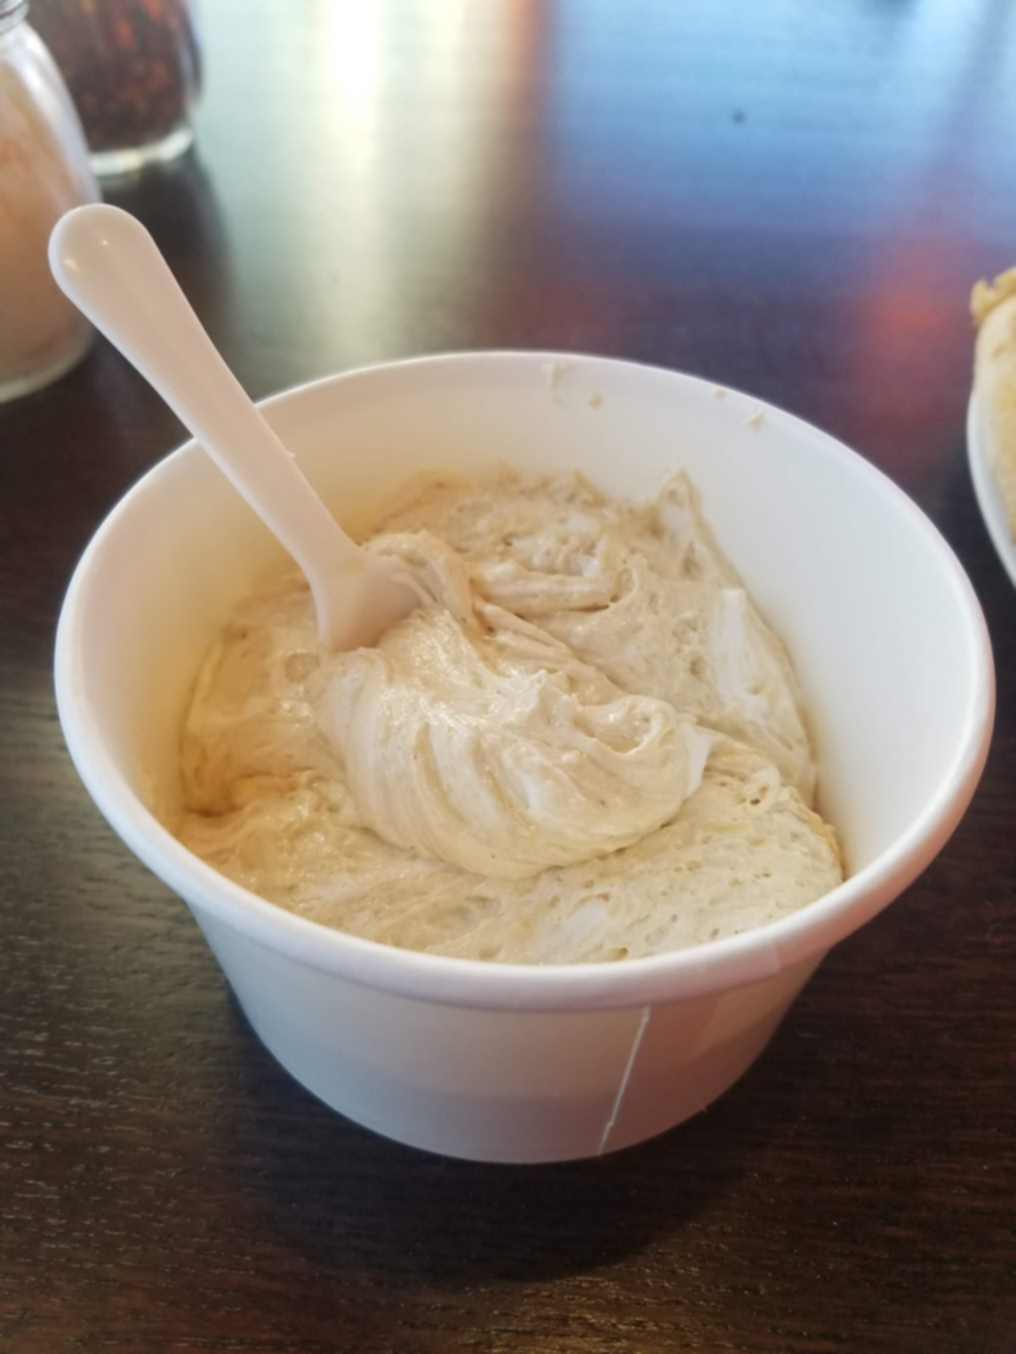

In [ ]:
image_vec = cv2.imread('image.jpg', 1)

g_blurred = cv2.GaussianBlur(image_vec, (5, 5), 0)

cv2_imshow(g_blurred)

### **Second Step:** Edge Detection- allows for more specific edge detections.


In [ ]:
blurred_float = g_blurred.astype(np.float32) / 255.0


In [ ]:
edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("/content/model.yml.gz")
edges = edgeDetector.detectEdges(blurred_float) * 255.0
cv2.imwrite('edge-raw.jpg', edges)

True

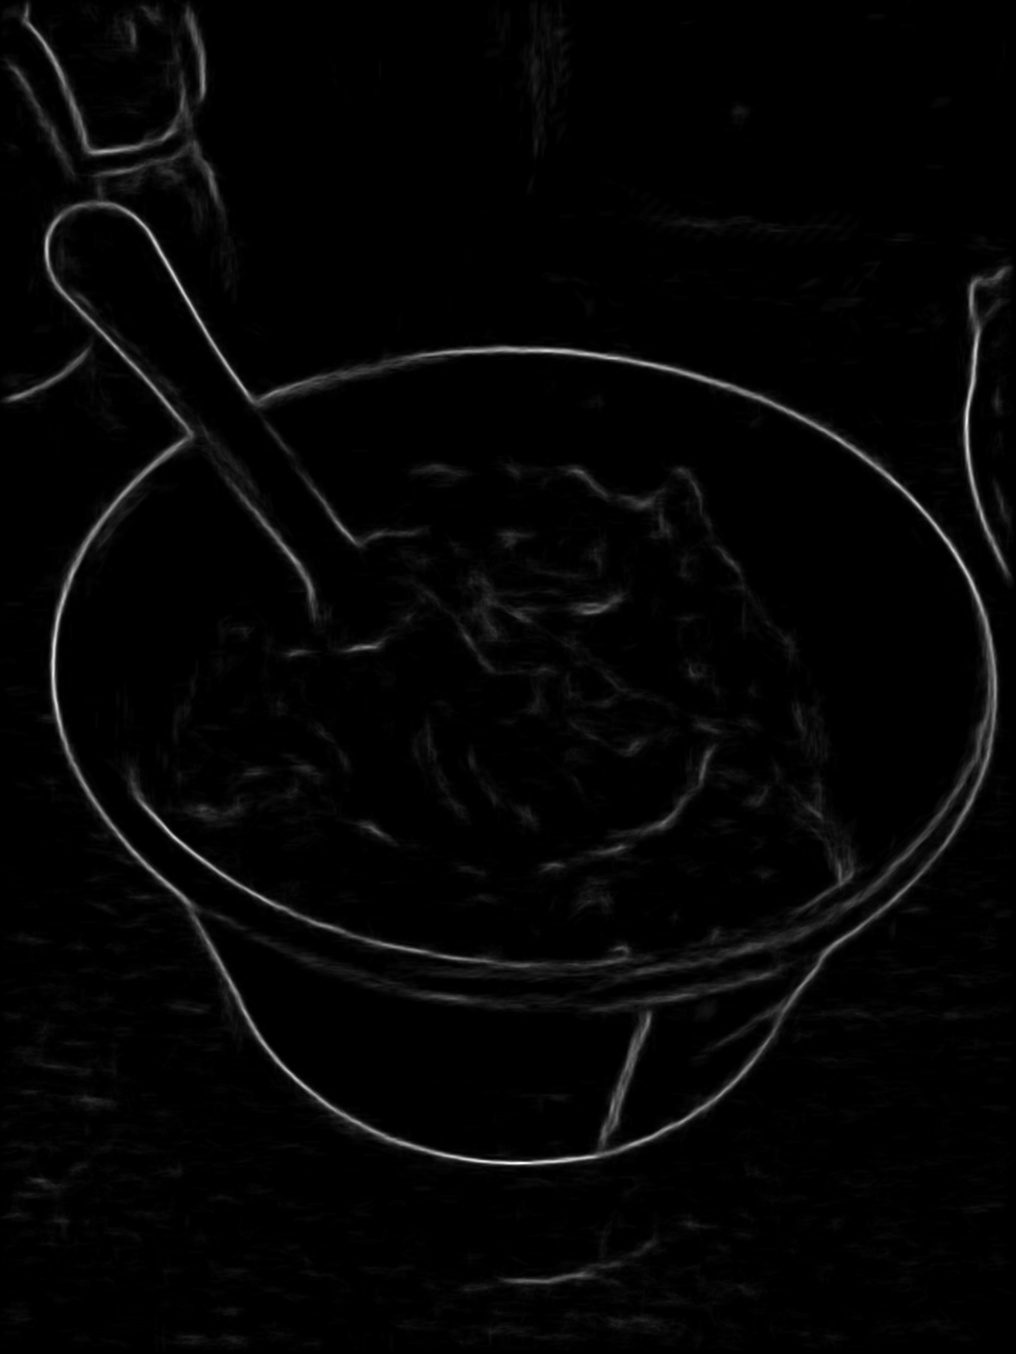

In [ ]:
from google.colab.patches import cv2_imshow
Edgedimage = cv2.imread("/content/edge-raw.jpg") 
cv2_imshow(Edgedimage)


### **Third Step:** Filtration- To Filter Out Salt and Pepper Noise using Median Filter

In [ ]:
def filterOutSaltPepperNoise(edgeImg):
    # Get rid of salt & pepper noise.
    count = 0
    lastMedian = edgeImg
    median = cv2.medianBlur(edgeImg, 3)
    while not np.array_equal(lastMedian, median):
        # get those pixels that gets zeroed out
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        count = count + 1
        if count > 70:
            break
        lastMedian = median
        median = cv2.medianBlur(edgeImg, 3)


edges_8u = np.asarray(edges, np.uint8)
filterOutSaltPepperNoise(edges_8u)
cv2.imwrite('edge.jpg', edges_8u)

True

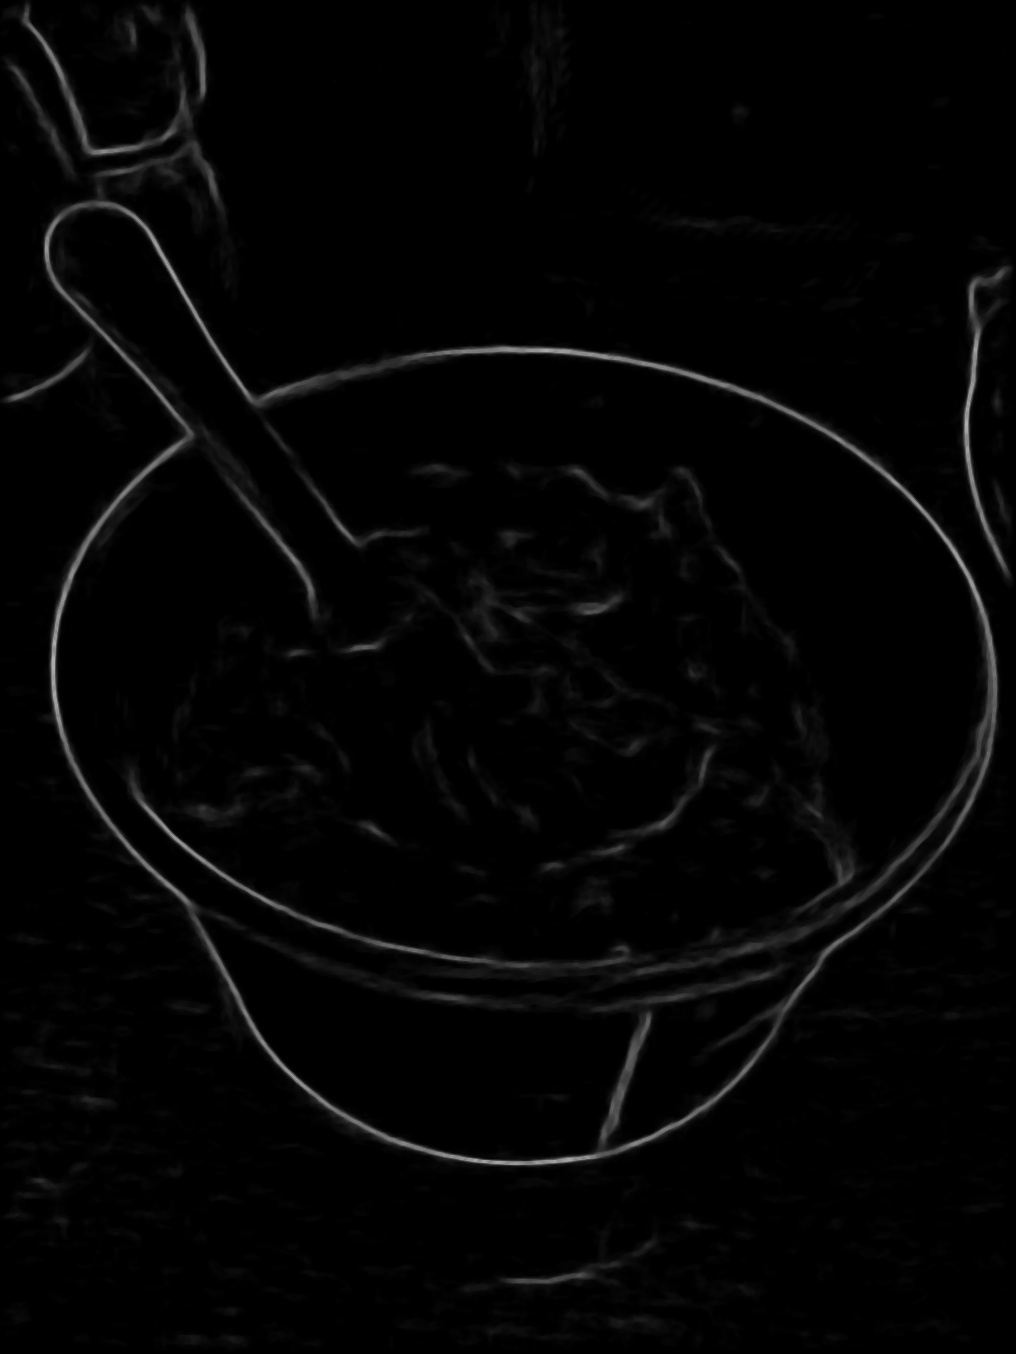

In [ ]:
img = cv2.imread('edge.jpg') # Load image
img_median = cv2.medianBlur(img, 5) # Add median filter to image
cv2.imwrite('median.jpg', img_median)


Medianimage = cv2.imread("/content/median.jpg") 
cv2_imshow(Medianimage) # Display img with median filter

### **Fourth step:** Find Significant Contours- This process clearly delineates the outline (contour) of the main object detected. 

In [ ]:
def findSignificantContour(edgeImg):
    contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
        # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
# From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])
    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour

contour = findSignificantContour(edges_8u)
# Draw the contour on the original image
contourImg = np.copy(image_vec)
cv2.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
cv2.imwrite('contour.jpg', contourImg)

True

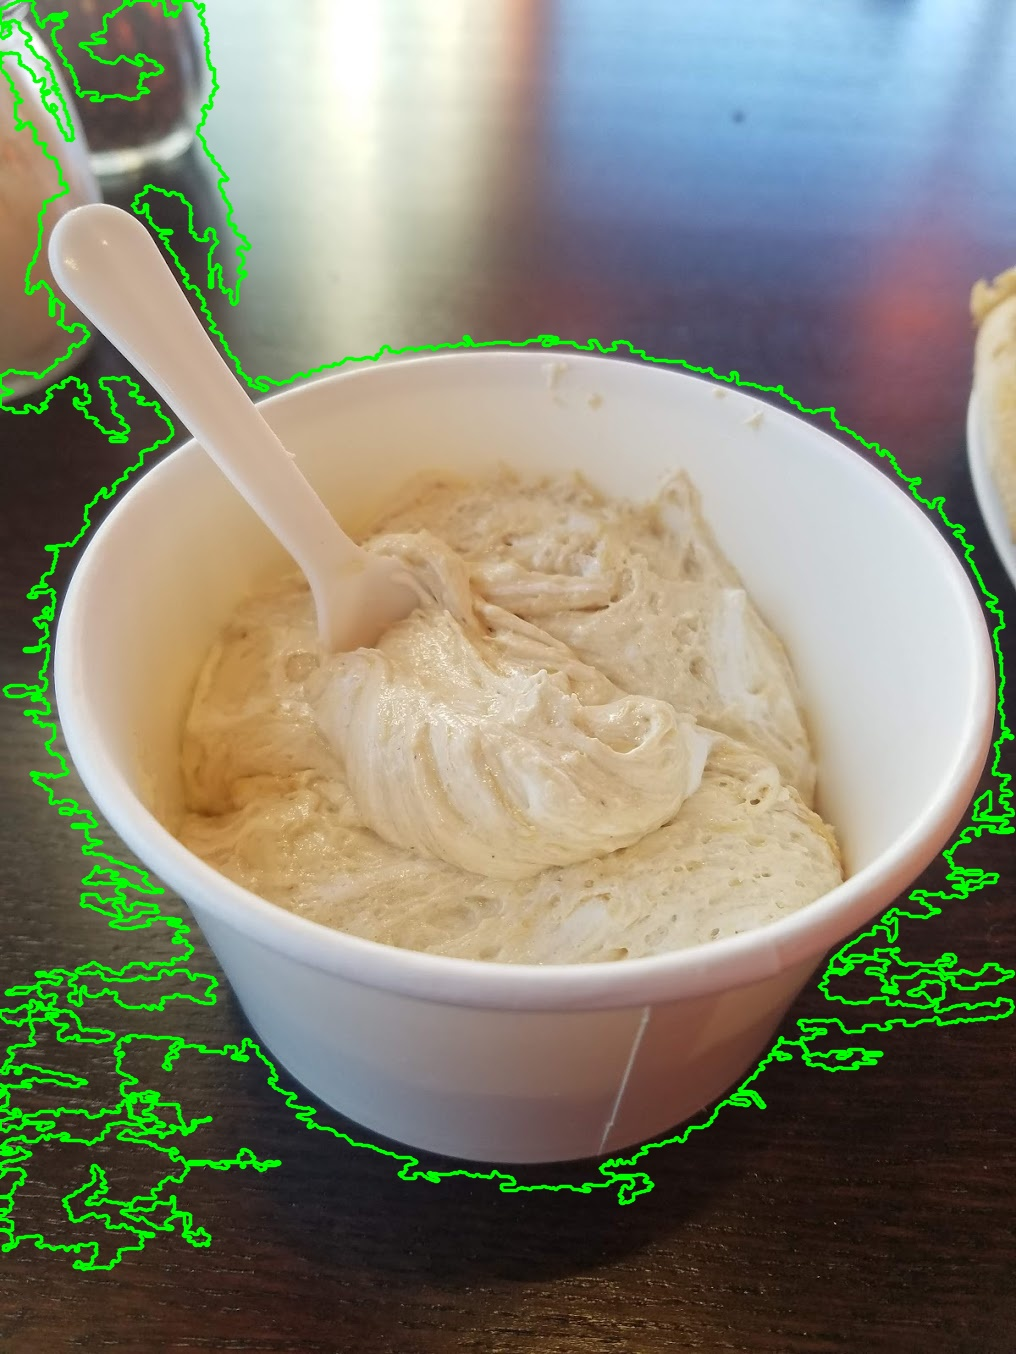

In [ ]:
Contourimage = cv2.imread("contour.jpg") 
cv2_imshow(Contourimage) # Display img with median filter

### **Fifth Step:** Masking Probable Background- Time to remove the background!

In [ ]:
mask = np.zeros_like(edges_8u)
cv2.fillPoly(mask, [contour], 255)

# calculate sure foreground area by dilating the mask
mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)

# mark inital mask as "probably background"
# and mapFg as sure foreground
trimap = np.copy(mask)
trimap[mask == 0] = cv2.GC_BGD
trimap[mask == 255] = cv2.GC_PR_BGD
trimap[mapFg == 255] = cv2.GC_FGD

# visualize trimap
trimap_print = np.copy(trimap)
trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
trimap_print[trimap_print == cv2.GC_FGD] = 255
cv2.imwrite('trimap.png', trimap_print)

True

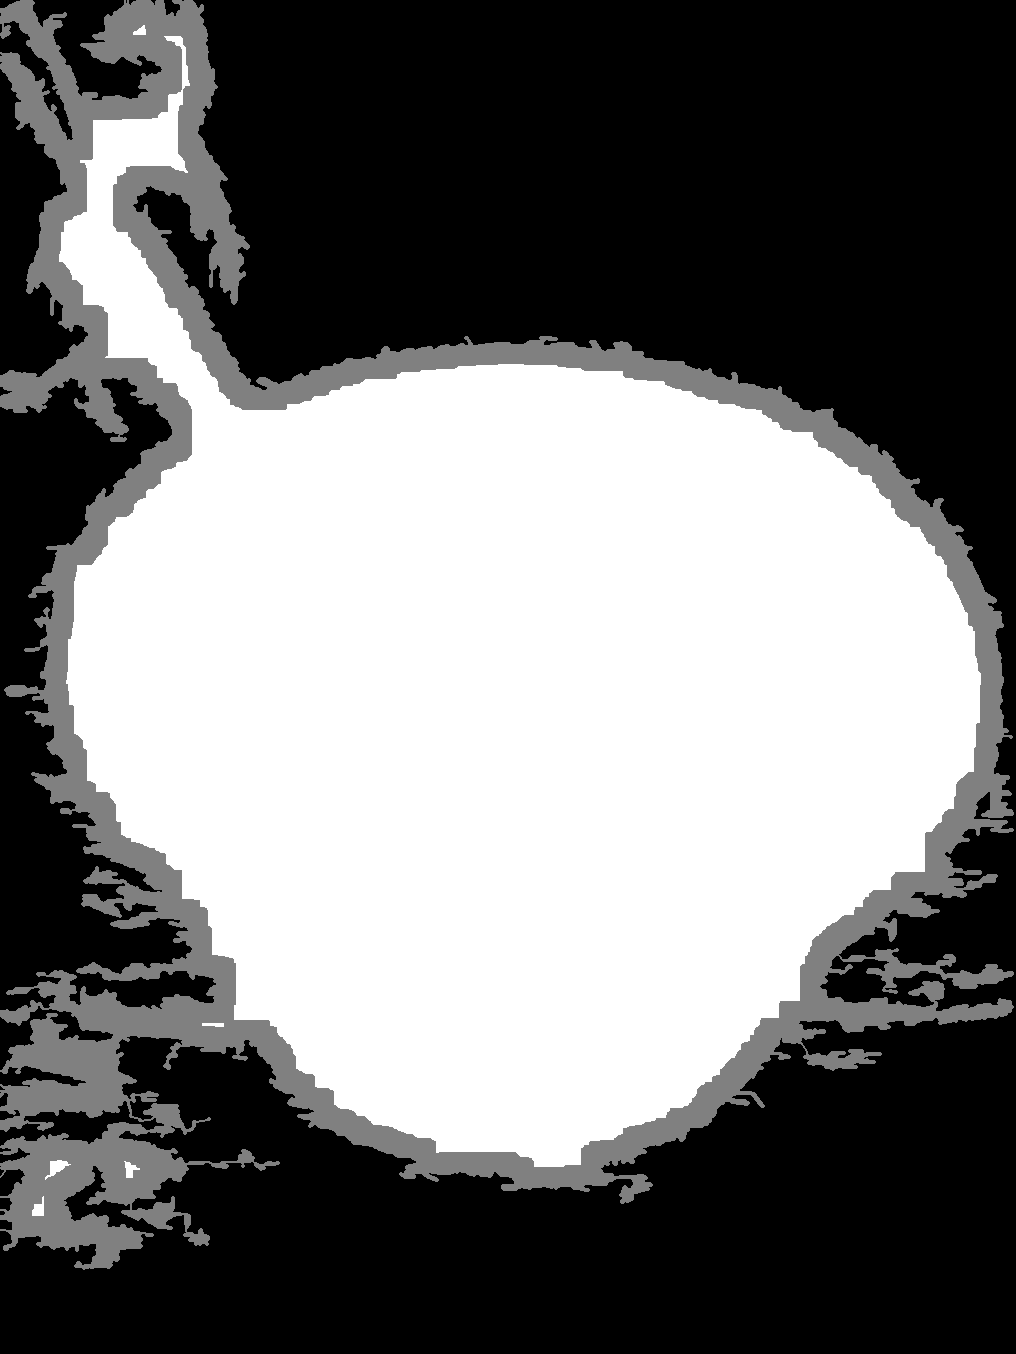

In [ ]:
MaskedImage = cv2.imread("trimap.png") 
cv2_imshow(MaskedImage) # Display img with median filter

Now, running **grabcut** algorithm: The masks a makes a clearer cut between the background and object.



In [ ]:
# run grabcut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
rect = (0, 0, mask.shape[0] - 1, mask.shape[1] - 1)
cv2.grabCut(image_vec, trimap, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

# create mask again
mask2 = np.where(
    (trimap == cv2.GC_FGD) | (trimap == cv2.GC_PR_FGD),
    255,
    0
).astype('uint8')
cv2.imwrite('mask2.jpg', mask2)

True

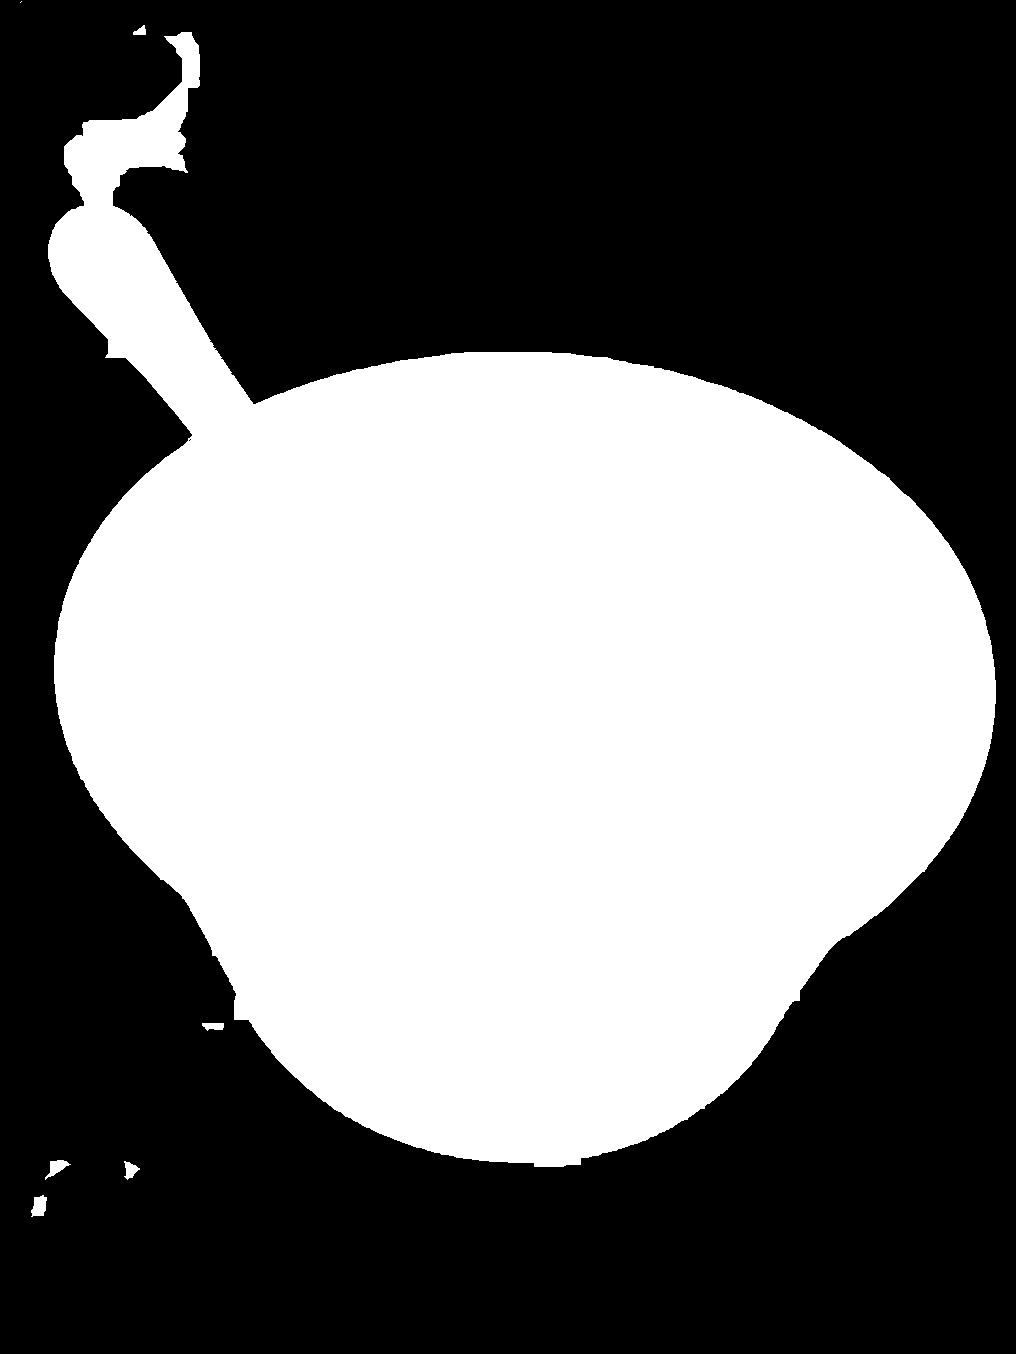

In [ ]:
Mask2Image = cv2.imread("mask2.jpg") 
cv2_imshow(Mask2Image) # Display img with grabcut mask filter

You will notice that there might a probable issue with this algorithm- It can leave out some inner parts of the image that we are attempting to cut depending on the complexity of the image.
As we know that most of the object is a single polygon, we can retcify the defect by running contour detection again and filling in the parts.

In [ ]:
contour2 = findSignificantContour(mask2)
mask3 = np.zeros_like(mask2)
cv2.fillPoly(mask3, [contour2], 255)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# blended alpha cut-out
mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
mask4 = cv2.GaussianBlur(mask3, (3, 3), 0)
alpha = mask4.astype(float) * 1.1  # making blend stronger
alpha[mask3 > 0] = 255.0
alpha[alpha > 255] = 255.0

foreground = np.copy(image_vec).astype(float)
foreground[mask4 == 0] = 0
background = np.ones_like(foreground, dtype=float) * 255.0

cv2.imwrite('foreground.png', foreground)
cv2.imwrite('background.png', background)
cv2.imwrite('alpha.png', alpha)

# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha / 255.0
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
# Add the masked foreground and background.
cutout = cv2.add(foreground, background)

cv2.imwrite('cutout.jpg', cutout)

True

### **Final Step:** lets do the final masking and display the colored image.

### Success!

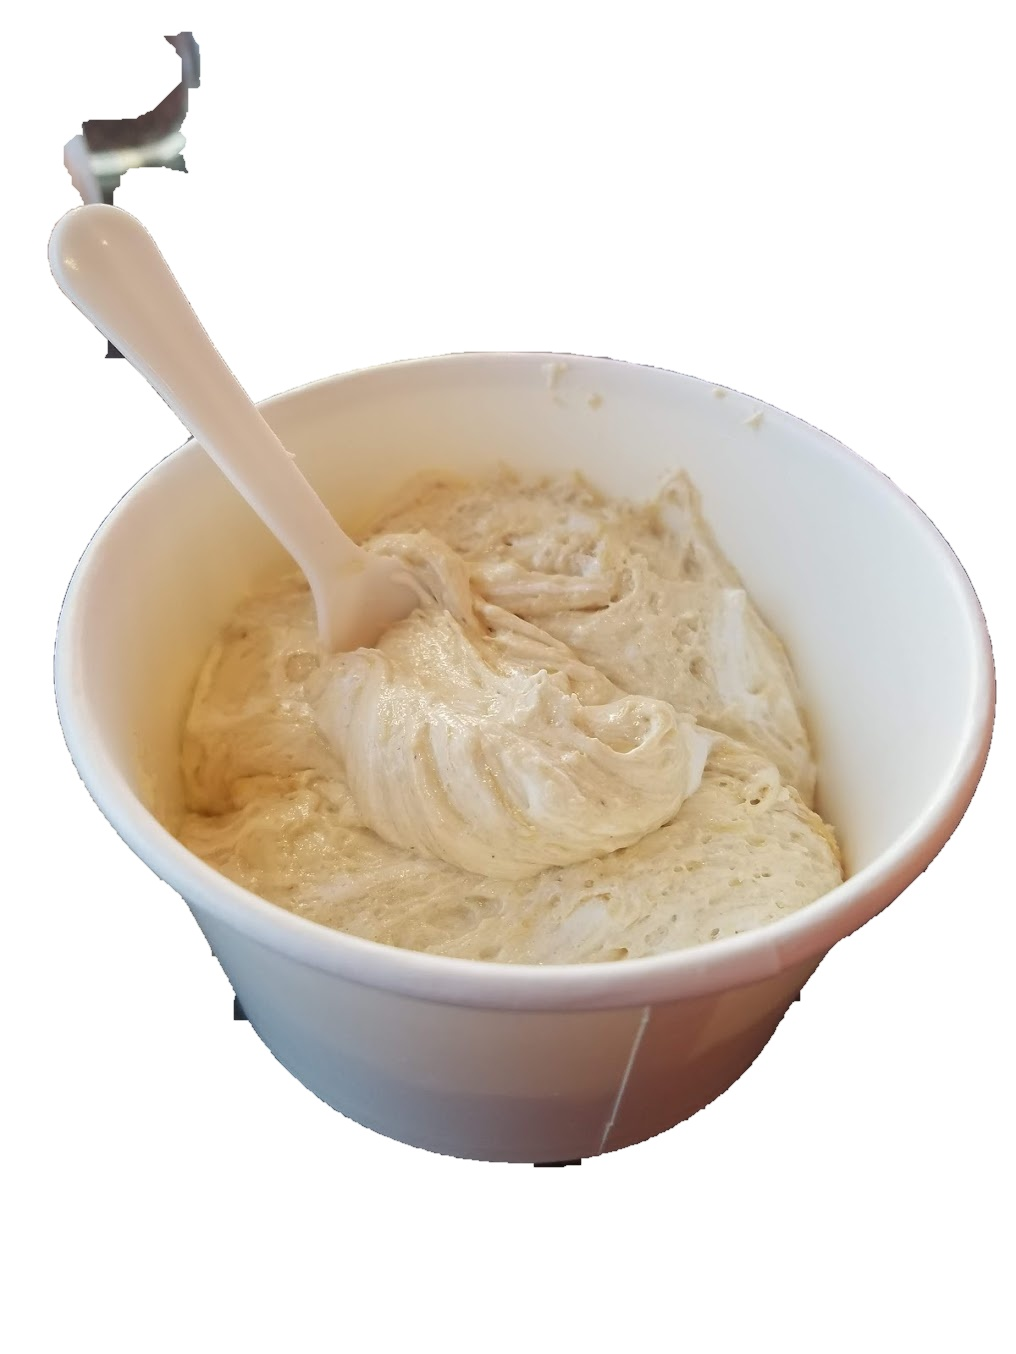

In [ ]:
FinalMaskImage = cv2.imread("cutout.jpg") 
cv2_imshow(FinalMaskImage) # Display img with grabcut mask filter

### **Final Remarks**

By this process, I observed that it is possible to remove the background of an image using a machine learning model. Although, it is not perfect and has bits of the background still displayed, the model can tentatively removed excess unrequired parts of the image. This in turn, will decrease the size of the image.
---

Thank You!

Resources: 


*   https://www.codepasta.com/computer-vision/2019/04/26/background-segmentation-removal-with-opencv-take-2.htmlh
*   https://docs.opencv.org/master/d1/dc5/tutorial_background_subtraction.html
*   https://medium.com/@chris.s.park/image-background-removal-using-opencv-part-1-da3695ac66b6
*   https://github.com/opencv/opencv_extra/blob/master/testdata/cv/ximgproc/model.yml.gz



